<a href="https://colab.research.google.com/github/sre-bhavin/Amazon_Review_POS_Tagging/blob/main/New_Assignment1_ProblemStatement20_Group215_AmazonReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP (AIMLCZG530) - Assignment 1 - Problem Statement 20 - Group 215
---
## Team Members & Contribution

| Student ID | Student Name | Contribution % |
|---|---|---|
| 2024aa05899 | Bhavin Arvindkumar Shah | 20% |
| xx | xx | 20% |
| xx | xx | 20% |
| xx | xx | 20% |
| xx | xx | 20% |

---

## Dataset Choosen - Amazon Product Review
**Justification:**
We have chosen the Amazon Product Review dataset for its rich linguistic diversity and relevance to real-world natural language processing tasks. This dataset contains a wide range of product reviews written by various users, reflecting different writing styles, sentiments, and domain-specific vocabulary. This diversity makes it an excellent testbed for developing robust Part-of-Speech (POS) tagging models.

**Dataset source:**
https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews


---




#### Download & import necessary Libraries & NLTK data

In [1]:
!pip install nltk scikit-learn pandas tensorflow

In [2]:
import pandas as pd
import nltk
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# Part 1: Data Preparation and Feature Engineering

## a. Data Loading and Preprocessing

### Read the text data, perform lowercasing and exploratory data analysis

Read amazon review file

In [4]:
df = pd.read_csv('amazon_review.csv')
print("Number of reviews :", len(df))
df.head()

Number of reviews : 1000


,polarity,title,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  1000 non-null   int64 
 1   title     999 non-null    object
 2   review    1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


Dropping unnecessary columns

In [6]:
df = df.drop(columns=['polarity', 'title'])
df.head()

,review
0,My lovely Pat has one of the GREAT voices of h...
1,Despite the fact that I have only played a sma...
2,I bought this charger in Jul 2003 and it worke...
3,Check out Maha Energy's website. Their Powerex...
4,Reviewed quite a bit of the combo players and ...


Lowercasing review text

In [7]:
df['review'] = df['review'].str.lower()
df.head()

,review
0,my lovely pat has one of the great voices of h...
1,despite the fact that i have only played a sma...
2,i bought this charger in jul 2003 and it worke...
3,check out maha energy's website. their powerex...
4,reviewed quite a bit of the combo players and ...


### Show dataset statistics: number of sentences, vocabulary size, POS tag distribution

Flattening sentences in review comments for better analysis

In [8]:
sentences = [nltk.sent_tokenize(text) for text in df['review'].tolist()]
flat_sentences = [sent for sublist in sentences for sent in sublist]
num_sentences = len(flat_sentences)

In [9]:
print("sentences:",len(sentences), type(sentences), sentences[0])
print("flat_sentences:",len(flat_sentences), type(flat_sentences), flat_sentences[0])

sentences: 1000 <class 'list'> ['my lovely pat has one of the great voices of her generation.', 'i have listened to this cd for years and i still love it.', "when i'm in a good mood it makes me feel better.", 'a bad mood just evaporates like sugar in the rain.', 'this cd just oozes life.', 'vocals are jusat stuunning and lyrics just kill.', "one of life's hidden gems.", 'this is a desert isle cd in my book.', 'why she never made it big is just beyond me.', 'everytime i play this, no matter black, white, young, old, male, female everybody says one thing "who was that singing ?"']
flat_sentences: 4675 <class 'list'> my lovely pat has one of the great voices of her generation.


### Handle special characters and normalize text appropriately

In [10]:
cleaned_sentences = [re.sub(r'[^A-Za-z0-9\s]', '', sent).strip() for sent in flat_sentences]

In [11]:
print("cleaned_sentences:",len(cleaned_sentences), type(cleaned_sentences), cleaned_sentences[0])

cleaned_sentences: 4675 <class 'list'> my lovely pat has one of the great voices of her generation


Tokenization for words to get vocabulary size

In [12]:
words = [nltk.word_tokenize(sentence) for sentence in cleaned_sentences]
flat_words = [word for sublist in words for word in sublist]
vocabulary = set(flat_words)
vocabulary_size = len(vocabulary)
print("vocabulary:",len(vocabulary), type(vocabulary))

vocabulary: 9930 <class 'set'>


POS tag distribution

In [13]:
pos_tags = [nltk.pos_tag(sentence_words) for sentence_words in words]
flat_pos_tags = [tag for sublist in pos_tags for word, tag in sublist]
pos_tag_counts = Counter(flat_pos_tags)
print("flat_pos_tags:",len(flat_pos_tags), type(flat_pos_tags))

flat_pos_tags: 75384 <class 'list'>


### Print Summary of Dataset

In [14]:
print("Dataset Statistics:")
print("Number of reviews :", len(df))
print(f"Number of sentences: {num_sentences}")
print(f"Vocabulary size: {vocabulary_size}")
print(f"all POS tags: {len(flat_pos_tags)}")
print(f"POS tag distribution: {pos_tag_counts.most_common(10)}") # Show top 10

Dataset Statistics:
Number of reviews : 1000
Number of sentences: 4675
Vocabulary size: 9930
all POS tags: 75384
POS tag distribution: [('NN', 14907), ('DT', 8692), ('IN', 8224), ('JJ', 6767), ('RB', 4893), ('NNS', 3805), ('VB', 3406), ('PRP', 3334), ('CC', 2873), ('VBD', 2705)]


Plotting POS Tag Counters

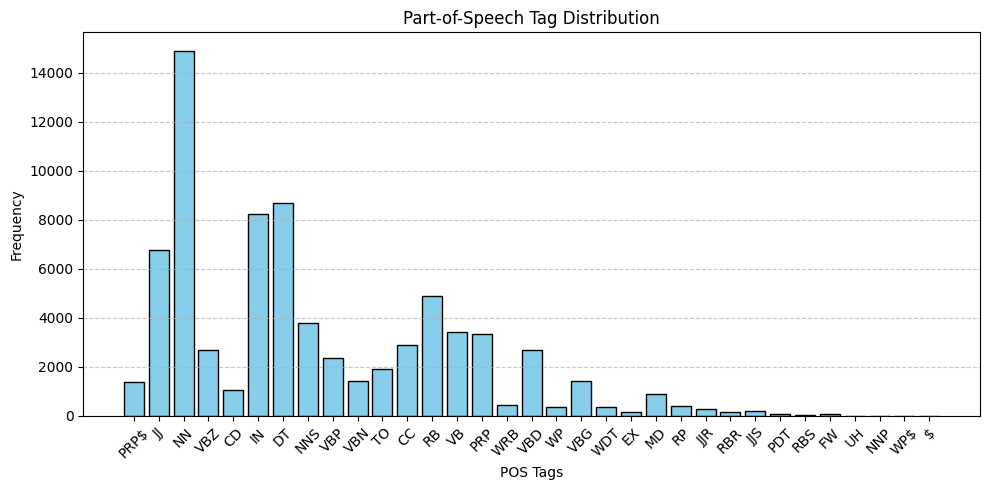

In [15]:
# Unpack the tags and their counts
tags, counts = zip(*pos_tag_counts.items())

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(tags, counts, color='skyblue', edgecolor='black')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('Part-of-Speech Tag Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## b. Tokenization, Encoding and Sequence Processing

### Implement tokenization for words and sentences

Create word and tag lists

In [16]:
all_words_with_tags = [(word, tag) for sent in pos_tags for word, tag in sent]

### Generate word-to-index and tag-to-index mappings

Generate word to index

In [17]:
word_to_index = {word: i + 1 for i, word in enumerate(sorted(list(vocabulary)))} # Add 1 for padding
word_to_index['<PAD>'] = 0 # Padding token
index_to_word = {i: word for word, i in word_to_index.items()}

Generate Tag to Index

In [18]:
all_tags = sorted(list(set(flat_pos_tags)))
tag_to_index = {tag: i + 1 for i, tag in enumerate(all_tags)} # Add 1 for padding
tag_to_index['<PAD>'] = 0 # Padding tag
index_to_tag = {i: tag for tag, i in tag_to_index.items()}

### Create vocabulary mappings and POS tag encodings

In [19]:
encoded_sequences = []
for sent in pos_tags:
    word_indices = [word_to_index.get(word, word_to_index['<PAD>']) for word, tag in sent]
    tag_indices = [tag_to_index.get(tag, tag_to_index['<PAD>']) for word, tag in sent]
    encoded_sequences.append((word_indices, tag_indices))

### Split data into training (70%), validation (15%), and test (15%) sets

In [20]:
train_sequences, temp_sequences = train_test_split(encoded_sequences, test_size=0.30, random_state=42)
val_sequences, test_sequences = train_test_split(temp_sequences, test_size=0.5, random_state=42)

### Print Summary

In [21]:
print("\nMapping Sizes:")
print(f"Word to index mapping size: {len(word_to_index)}")
print(f"Tag to index mapping size: {len(tag_to_index)}")


Mapping Sizes:
Word to index mapping size: 9931
Tag to index mapping size: 34


In [22]:
print("\nData Split:")
print(f"Number of training sequences: {len(train_sequences)}")
print(f"Number of validation sequences: {len(val_sequences)}")
print(f"Number of test sequences: {len(test_sequences)}")


Data Split:
Number of training sequences: 3272
Number of validation sequences: 701
Number of test sequences: 702


In [23]:
if encoded_sequences:
    sample_word_indices, sample_tag_indices = encoded_sequences[0]
    print("\nExample Encoded Sentence:")
    print("Word Indices:", sample_word_indices[:10], "...")
    print("Tag Indices:", sample_tag_indices[:10], "...")
    print("Original Words:", [index_to_word.get(idx, '<UNK>') for idx in sample_word_indices[:10]], "...")
    print("Original Tags:", [index_to_tag.get(idx, '<UNK>') for idx in sample_tag_indices[:10]], "...")


Example Encoded Sentence:
Word Indices: [5752, 5165, 6318, 3972, 6055, 6012, 8755, 3839, 9491, 6012] ...
Tag Indices: [17, 8, 12, 29, 3, 7, 4, 8, 14, 7] ...
Original Words: ['my', 'lovely', 'pat', 'has', 'one', 'of', 'the', 'great', 'voices', 'of'] ...
Original Tags: ['PRP$', 'JJ', 'NN', 'VBZ', 'CD', 'IN', 'DT', 'JJ', 'NNS', 'IN'] ...


## c. Feature Extraction for MEMM

Extracts features for each word in a sentence for MEMM.

In [24]:
def extract_features(sentence, word_index, tag_index, prev_tags=None):
    """
    Extracts features for each word in a sentence for MEMM.

    Args:
        sentence (list): A list of (word, tag) tuples for a sentence.
        word_index (dict): Mapping from word to index.
        tag_index (dict): Mapping from tag to index.
        prev_tags (list, optional): A list of previous tags (indices)
                                     for the sequence. Defaults to None.

    Returns:
        list: A list of feature dictionaries, one for each word in the sentence.
    """
    features = []
    sentence_length = len(sentence)

    # Ensure prev_tags is initialized as a list of padding indices if not provided
    if prev_tags is None:
        prev_tags = [tag_index.get('<PAD>', 0)] * sentence_length # Placeholder, will be updated dynamically

    for i in range(sentence_length):
        word, current_tag = sentence[i]
        word_idx = word_to_index.get(word, word_to_index.get('<PAD>', 0))
        tag_idx = tag_to_index.get(current_tag, tag_to_index.get('<PAD>', 0))

        # Handle previous tags dynamically or using the provided sequence
        prev_tag_idx = prev_tags[i-1] if i > 0 else tag_index.get('<PAD>', 0)
        prev_prev_tag_idx = prev_tags[i-2] if i > 1 else tag_index.get('<PAD>', 0)

        feature_dict = {
            # Current word and its properties
            'word': word,
            'word_idx': word_idx,
            'word.lower()': word.lower(),
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
            'word_length': len(word),

            # Context features
            'prev_word': sentence[i-1][0] if i > 0 else '<START>',
            'prev_word_idx': word_to_index.get(sentence[i-1][0], word_to_index.get('<PAD>', 0)) if i > 0 else word_to_index.get('<PAD>', 0),
            'next_word': sentence[i+1][0] if i < sentence_length - 1 else '<END>',
            'next_word_idx': word_to_index.get(sentence[i+1][0], word_to_index.get('<PAD>', 0)) if i < sentence_length - 1 else word_to_index.get('<PAD>', 0),
            'prev_tag_idx': prev_tag_idx, # This should ideally be the predicted tag
            'prev_prev_tag_idx': prev_prev_tag_idx, # This should ideally be the predicted tag

            # Morphological features
            'prefix-1': word[0] if len(word) > 0 else '',
            'prefix-2': word[:2] if len(word) > 1 else '',
            'prefix-3': word[:3] if len(word) > 2 else '',
            'suffix-1': word[-1] if len(word) > 0 else '',
            'suffix-2': word[-2:] if len(word) > 1 else '',
            'suffix-3': word[-3:] if len(word) > 2 else '',
            'word_shape': re.sub(r'[A-Z]', 'X', re.sub(r'[a-z]', 'x', re.sub(r'[0-9]', 'd', word))),

            # Position features
            'is_first': i == 0,
            'is_last': i == sentence_length - 1,

            # The target variable (current tag) is NOT a feature for MEMM,
            # but we might store it for convenience during training.
            # 'current_tag_idx': tag_idx
        }
        features.append(feature_dict)
    return features

Example usage on a sample sentence from the training data

In [25]:
# Example usage on a sample sentence from the training data
# We need the original (word, tag) tuples to extract features
# Let's reconstruct a sample sentence from the first encoded training sequence
sample_encoded_sequence = train_sequences[0]
sample_word_indices, sample_tag_indices = sample_encoded_sequence
sample_sentence_with_tags = [(index_to_word.get(w_idx, '<UNK>'), index_to_tag.get(t_idx, '<UNK>'))
                             for w_idx, t_idx in zip(sample_word_indices, sample_tag_indices)]

print("sample_sentence_with_tags",len(sample_sentence_with_tags),type(sample_sentence_with_tags), sample_sentence_with_tags)

sample_sentence_with_tags 15 <class 'list'> [('we', 'PRP'), ('bought', 'VBD'), ('this', 'DT'), ('emer', 'NN'), ('galilieo', 'NN'), ('vacuum', 'NN'), ('cleaner', 'JJR'), ('for', 'IN'), ('about', 'RB'), ('400', 'CD'), ('more', 'JJR'), ('than', 'IN'), ('one', 'CD'), ('year', 'NN'), ('ago', 'RB')]


In [26]:
# For feature extraction in the training phase, we use the true previous tags.
# For prediction (inference), we will use the previously predicted tags.
# Let's get the actual previous tag indices for the sample sentence
sample_true_prev_tag_indices = [tag_to_index.get(tag, tag_to_index.get('<PAD>', 0)) for _, tag in sample_sentence_with_tags]
sample_features = extract_features(sample_sentence_with_tags, word_to_index, tag_to_index, prev_tags=sample_true_prev_tag_indices)

In [27]:
print("\nFeatures for the first few words of a sample sentence:")
for j, feature in enumerate(sample_features[:5]):
    print(f"Word: {sample_sentence_with_tags[j][0]}")
    # Print a subset of features for clarity
    print({k: feature[k] for k in ['word', 'word.isupper()', 'prev_word', 'next_word', 'prev_tag_idx', 'is_first', 'suffix-3']})
    print("-" * 20)



Features for the first few words of a sample sentence:
Word: we
{'word': 'we', 'word.isupper()': False, 'prev_word': '<START>', 'next_word': 'bought', 'prev_tag_idx': 0, 'is_first': True, 'suffix-3': ''}
--------------------
Word: bought
{'word': 'bought', 'word.isupper()': False, 'prev_word': 'we', 'next_word': 'this', 'prev_tag_idx': 16, 'is_first': False, 'suffix-3': 'ght'}
--------------------
Word: this
{'word': 'this', 'word.isupper()': False, 'prev_word': 'bought', 'next_word': 'emer', 'prev_tag_idx': 25, 'is_first': False, 'suffix-3': 'his'}
--------------------
Word: emer
{'word': 'emer', 'word.isupper()': False, 'prev_word': 'this', 'next_word': 'galilieo', 'prev_tag_idx': 4, 'is_first': False, 'suffix-3': 'mer'}
--------------------
Word: galilieo
{'word': 'galilieo', 'word.isupper()': False, 'prev_word': 'emer', 'next_word': 'vacuum', 'prev_tag_idx': 12, 'is_first': False, 'suffix-3': 'ieo'}
--------------------


# Part 2: Model Implementation

## Model 1: Maximum Entropy Markov Model (MEMM)

Creates feature vectors (X) and labels (y) for MEMM training.

In [28]:
def create_memm_data(sequences):
    """
    Creates feature vectors (X) and labels (y) for MEMM training.
    Features are extracted using true previous tags during training.
    """
    X = []
    y = []
    for word_indices, tag_indices in sequences:
        sentence_words_tags = [(index_to_word.get(w_idx, '<UNK>'), index_to_tag.get(t_idx, '<UNK>'))
                               for w_idx, t_idx in zip(word_indices, tag_indices)]
        # Extract features using true previous tags for training
        sentence_features = extract_features(sentence_words_tags, word_to_index, tag_to_index, prev_tags=tag_indices)
        X.extend(sentence_features)
        y.extend([tag_to_index.get(tag, tag_to_index.get('<PAD>', 0)) for _, tag in sentence_words_tags])
    return X, y

Prepare data for MEMM

In [29]:
X_train_memm, y_train_memm = create_memm_data(train_sequences)

In [30]:
X_val_memm, y_val_memm = create_memm_data(val_sequences)

In [31]:
X_test_memm, y_test_memm = create_memm_data(test_sequences)

Creating MEMM model

In [32]:
# Build the MEMM pipeline
# 1. DictVectorizer to convert dictionaries of features into a numerical feature matrix
# 2. LogisticRegression for the classification of each word's tag
memm_pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=True)), # sparse=True is efficient for sparse features
    ('classifier', LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200, C=1.0, penalty='l2', n_jobs=-1, verbose=1 )) # Add regularization
])

Train the MEMM model

In [33]:
memm_pipeline.fit(X_train_memm, y_train_memm)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Pipeline(steps=[('vectorizer', DictVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=200, multi_class='auto', n_jobs=-1,
                                    verbose=1))])

Token-level accuracy on the validation set

In [34]:
y_val_pred_token = memm_pipeline.predict(X_val_memm)
token_accuracy_memm = accuracy_score(y_val_memm, y_val_pred_token)
print(f"MEMM Token-level accuracy on validation set: {token_accuracy_memm:.4f}")

MEMM Token-level accuracy on validation set: 0.2138


In [35]:
def viterbi_memm(sentence_words, memm_pipeline, word_to_index, tag_to_index, index_to_tag):
    """
    Performs Viterbi decoding for MEMM.

    Args:
        sentence_words (list): A list of words in the sentence.
        memm_pipeline: Trained MEMM pipeline (DictVectorizer + LogisticRegression).
        word_to_index (dict): Mapping from word to index.
        tag_to_index (dict): Mapping from tag to index.
        index_to_tag (dict): Mapping from index to tag.

    Returns:
        list: The predicted sequence of tags for the sentence.
    """
    num_tags = len(tag_to_index)
    sentence_length = len(sentence_words)

    # Initialize DP table (delta[i][k] = max probability of a tag sequence ending with tag k at word i)
    delta = np.zeros((sentence_length, num_tags))
    # Initialize backpointer table (psi[i][k] = index of the previous tag that maximizes probability)
    psi = np.zeros((sentence_length, num_tags), dtype=int)

    # Get the index for the padding tag, which we'll treat as the start tag
    pad_tag_idx = tag_to_index.get('<PAD>', 0)
    # Get all possible tag indices (excluding padding for emissions/transitions)
    all_tag_indices = [idx for tag, idx in tag_to_index.items() if tag != '<PAD>']
    start_tag_idx = pad_tag_idx # Use padding tag index as a placeholder for start

    # For the first word (i=0)
    current_word = sentence_words[0]
    # Features for the first word (using <START> for previous word/tag)
    features_0 = extract_features([(current_word, '<PAD>')], word_to_index, tag_to_index, prev_tags=[start_tag_idx])[0]
    # Convert features to numerical vector
    X_0 = memm_pipeline.named_steps['vectorizer'].transform([features_0])

    # Get log probabilities for each tag for the first word
    # P(tag_0 | features_0)
    log_probs_0 = memm_pipeline.named_steps['classifier'].predict_log_proba(X_0)[0]

    # delta[0][k] = P(tag_0 = k | features_0)
    for k in all_tag_indices:
         # Ensure the tag index exists in the model's classes_
        if k in memm_pipeline.named_steps['classifier'].classes_:
            # Find the column index for the current tag index k in the log_probs_0 array
            col_index = np.where(memm_pipeline.named_steps['classifier'].classes_ == k)[0]
            if len(col_index) > 0:
                 delta[0][k] = log_probs_0[col_index[0]]
            else:
                 delta[0][k] = -np.inf # Tag not in classifier's vocabulary
        else:
             delta[0][k] = -np.inf # Tag not in classifier's vocabulary


    # For words i = 1 to sentence_length - 1
    for i in range(1, sentence_length):
        current_word = sentence_words[i]

        for k in all_tag_indices: # Iterate over possible current tags k
             # Ensure the tag index exists in the model's classes_
            if k not in memm_pipeline.named_steps['classifier'].classes_:
                 delta[i][k] = -np.inf
                 continue # Skip if the tag is not in the classifier's output classes

            max_prob = -np.inf
            best_prev_tag_idx = -1

            for j in all_tag_indices: # Iterate over possible previous tags j
                 # Ensure the previous tag index exists in the model's classes_
                if delta[i-1][j] == -np.inf:
                    continue # Skip if the probability of ending with tag j at i-1 is zero

                # Features for the current word, using the assumed previous tag j
                # Note: Here's where MEMM differs. Features include the *assumed* previous tag.
                features_i = extract_features([(current_word, '<PAD>')], word_to_index, tag_to_index, prev_tags=[pad_tag_idx] * (i) + [j] + [pad_tag_idx] * (sentence_length - i - 1))[0]
                # Convert features to numerical vector
                X_i = memm_pipeline.named_steps['vectorizer'].transform([features_i])

                # Get log probabilities for each tag for the current word
                # P(tag_i | tag_{i-1}=j, features_i)
                log_probs_i = memm_pipeline.named_steps['classifier'].predict_log_proba(X_i)[0]

                # Find the log probability of the current tag k given features_i
                # This is log P(tag_i=k | tag_{i-1}=j, features_i)
                col_index_k = np.where(memm_pipeline.named_steps['classifier'].classes_ == k)[0]
                if len(col_index_k) > 0:
                    log_prob_current_tag = log_probs_i[col_index_k[0]]
                else:
                    log_prob_current_tag = -np.inf # Should not happen if k is in all_tag_indices and model classes

                # Probability of the path ending with tag j at i-1 and tag k at i
                current_path_prob = delta[i-1][j] + log_prob_current_tag

                if current_path_prob > max_prob:
                    max_prob = current_path_prob
                    best_prev_tag_idx = j

            delta[i][k] = max_prob
            psi[i][k] = best_prev_tag_idx

    # Backtrack to find the best tag sequence
    best_sequence = [0] * sentence_length

    # Find the last tag (tag at sentence_length - 1)
    best_last_tag_idx = np.argmax(delta[sentence_length - 1, all_tag_indices])
    best_sequence[sentence_length - 1] = all_tag_indices[best_last_tag_idx]

    # Backtrack from sentence_length - 2 down to 0
    for i in range(sentence_length - 2, -1, -1):
        best_sequence[i] = psi[i+1][best_sequence[i+1]]

    # Convert tag indices back to tag strings
    predicted_tags = [index_to_tag.get(idx, '<UNK>') for idx in best_sequence]

    return predicted_tags

Example of Viterbi decoding on a sample test sentence

In [36]:
sample_test_encoded = test_sequences[0]
sample_test_word_indices, sample_test_tag_indices = sample_test_encoded
sample_test_words = [index_to_word.get(w_idx, '<UNK>') for w_idx in sample_test_word_indices]
sample_true_tags = [index_to_tag.get(t_idx, '<UNK>') for t_idx in sample_test_tag_indices]

predicted_tags_memm = viterbi_memm(sample_test_words, memm_pipeline, word_to_index, tag_to_index, index_to_tag)

print("\nMEMM Viterbi Decoding Example:")
print("Sentence:", sample_test_words)
print("True Tags:", sample_true_tags)
print("Predicted Tags (MEMM):", predicted_tags_memm)


MEMM Viterbi Decoding Example:
Sentence: ['then', 'i', 'realized', 'that', 'i', 'needed', 'more', 'light']
True Tags: ['RB', 'VB', 'VBD', 'IN', 'NN', 'VBD', 'RBR', 'JJ']
Predicted Tags (MEMM): ['TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO']


Evaluate MEMM Viterbi decoding on the test set

In [41]:
def evaluate_memm_viterbi(test_sequences, memm_pipeline, word_to_index, tag_to_index, index_to_tag):
    correct_tags = 0
    total_tags = 0
    iteration = 0
    print("test_sequences count:", len(test_sequences))
    for word_indices, tag_indices in test_sequences:

        iteration = iteration  + 1

        sentence_words = [index_to_word.get(w_idx, '<UNK>') for w_idx in word_indices]
        true_tags = [index_to_tag.get(t_idx, '<UNK>') for t_idx in tag_indices]

        # Skip sentences with only padding or empty
        if not sentence_words or all(word == '<UNK>' or word == '<PAD>' for word in sentence_words):
            continue

        predicted_tags = viterbi_memm(sentence_words, memm_pipeline, word_to_index, tag_to_index, index_to_tag)

        # Compare predicted tags with true tags (ignoring padding)
        for true_tag, predicted_tag in zip(true_tags, predicted_tags):
            if true_tag != '<PAD>': # Do not count padding in accuracy calculation
                 if true_tag == predicted_tag:
                    correct_tags += 1
                 total_tags += 1
        print(f"Iteration: {iteration}, total_tags: {total_tags}, correct_tags: {correct_tags}")
        if (iteration > 30):
          print("Stopping after 30 epochs.")
          break

    accuracy = correct_tags / total_tags if total_tags > 0 else 0
    return accuracy

In [ ]:
memm_viterbi_accuracy = evaluate_memm_viterbi(test_sequences, memm_pipeline, word_to_index, tag_to_index, index_to_tag)
print(f"MEMM Viterbi accuracy on test set: {memm_viterbi_accuracy:.4f}")

test_sequences count: 702
Iteration: 1, total_tags: 8, correct_tags: 0
Iteration: 2, total_tags: 20, correct_tags: 0
Iteration: 3, total_tags: 42, correct_tags: 2
Iteration: 4, total_tags: 57, correct_tags: 2
Iteration: 5, total_tags: 82, correct_tags: 6
Iteration: 6, total_tags: 90, correct_tags: 6
Iteration: 7, total_tags: 103, correct_tags: 6
Iteration: 8, total_tags: 104, correct_tags: 6
Iteration: 9, total_tags: 119, correct_tags: 6
Iteration: 10, total_tags: 136, correct_tags: 6
Iteration: 11, total_tags: 141, correct_tags: 6
Iteration: 12, total_tags: 165, correct_tags: 10
Iteration: 13, total_tags: 172, correct_tags: 10
Iteration: 14, total_tags: 187, correct_tags: 11
Iteration: 15, total_tags: 201, correct_tags: 11
Iteration: 16, total_tags: 208, correct_tags: 12
Iteration: 17, total_tags: 247, correct_tags: 14
Iteration: 18, total_tags: 290, correct_tags: 19
Iteration: 19, total_tags: 306, correct_tags: 19
Iteration: 20, total_tags: 311, correct_tags: 19


## Model 2: Traditional HMM Baseline

Creating HMM model

In [ ]:
# Reconstruct word-tag sequences from encoded sequences for HMM
train_word_tag_sequences = [
    [(index_to_word.get(w_idx, '<UNK>'), index_to_tag.get(t_idx, '<UNK>'))
     for w_idx, t_idx in zip(word_indices, tag_indices) if index_to_tag.get(t_idx, '<UNK>') != '<PAD>'] # Exclude padding
    for word_indices, tag_indices in train_sequences
    if any(index_to_tag.get(t_idx, '<UNK>') != '<PAD>' for t_idx in tag_indices) # Skip empty sentences after removing padding
]

In [ ]:
# Collect all tags and words from the training data (excluding padding)
train_tags = [tag for sent in train_word_tag_sequences for word, tag in sent]
train_words = [word for sent in train_word_tag_sequences for word, tag in sent]

In [ ]:
# Count frequencies
tag_counts = Counter(train_tags)
word_tag_counts = Counter([(word, tag) for sent in train_word_tag_sequences for word, tag in sent])

In [ ]:
# Calculate transition probabilities P(tag_i | tag_{i-1})
transition_counts = Counter()
for sent in train_word_tag_sequences:
    # Add a virtual start tag
    sentence_tags = ['<START>'] + [tag for word, tag in sent]
    for i in range(1, len(sentence_tags)):
        transition_counts[(sentence_tags[i-1], sentence_tags[i])] += 1

In [ ]:
# Add a virtual start tag count for calculating probabilities from START
tag_counts['<START>'] = len(train_word_tag_sequences) # Number of sentences

transition_probabilities = {}
for (tag1, tag2), count in transition_counts.items():
    transition_probabilities[(tag1, tag2)] = count / tag_counts[tag1]

In [ ]:
# Calculate emission probabilities P(word | tag)
emission_probabilities = {}
for (word, tag), count in word_tag_counts.items():
    emission_probabilities[(word, tag)] = count / tag_counts[tag]

In [ ]:
# Implement smoothing for unseen word-tag combinations (Add-k smoothing)
k_smoothing = 0.1 # Small smoothing value
all_words_set = set(train_words)
all_tags_set = set(train_tags) # Excludes <START>
vocabulary_size_hmm = len(all_words_set)
num_tags_hmm = len(all_tags_set)


In [ ]:
# Smoothed emission probabilities
smoothed_emission_probabilities = {}
# Iterate over all possible (word, tag) pairs to apply smoothing
for word in all_words_set:
    for tag in all_tags_set:
        count = word_tag_counts.get((word, tag), 0)
        tag_count = tag_counts.get(tag, 0) # Use 0 if tag somehow isn't in counts (shouldn't happen with how we collected train_tags)
        # Apply add-k smoothing: (count + k) / (total_count_of_tag + k * vocabulary_size)
        smoothed_emission_probabilities[(word, tag)] = (count + k_smoothing) / (tag_count + k_smoothing * vocabulary_size_hmm)


In [ ]:
# For words not seen in training, use a small probability or handle specifically during Viterbi
# We'll handle unseen words during Viterbi by giving them a small default emission probability.
default_unseen_emission_prob = k_smoothing / (num_tags_hmm + k_smoothing * vocabulary_size_hmm) # A very small value


In [ ]:
# Implement Viterbi algorithm for HMM
def viterbi_hmm(sentence_words, transition_probabilities, emission_probabilities, tag_counts, all_tags_set, default_unseen_emission_prob):
    """
    Performs Viterbi decoding for HMM.

    Args:
        sentence_words (list): A list of words in the sentence.
        transition_probabilities (dict): P(tag_i | tag_{i-1}).
        emission_probabilities (dict): P(word | tag).
        tag_counts (Counter): Counts of each tag.
        all_tags_set (set): Set of all unique tags.
        default_unseen_emission_prob (float): Probability for unseen word-tag pairs.

    Returns:
        list: The predicted sequence of tags for the sentence.
    """
    num_tags = len(all_tags_set)
    tags_list = sorted(list(all_tags_set)) # Ordered list of tags
    tag_to_idx_hmm = {tag: i for i, tag in enumerate(tags_list)}
    idx_to_tag_hmm = {i: tag for tag, i in tag_to_idx_hmm.items()}

    sentence_length = len(sentence_words)

    if sentence_length == 0:
        return []

    # Initialize DP table (delta[i][k] = max probability of a tag sequence ending with tag k at word i)
    delta = np.zeros((sentence_length, num_tags))
    # Initialize backpointer table (psi[i][k] = index of the previous tag that maximizes probability)
    psi = np.zeros((sentence_length, num_tags), dtype=int)

    # For the first word (i=0)
    word_0 = sentence_words[0]
    for k_idx, tag_k in enumerate(tags_list):
        # P(tag_0 = k | <START>) * P(word_0 | tag_0 = k)
        prob_start_to_k = transition_probabilities.get(('<START>', tag_k), 0) # Use 0 if no transition from START
        prob_emit_word0_from_k = emission_probabilities.get((word_0, tag_k), default_unseen_emission_prob)

        delta[0][k_idx] = prob_start_to_k * prob_emit_word0_from_k

    # For words i = 1 to sentence_length - 1
    for i in range(1, sentence_length):
        current_word = sentence_words[i]
        for k_idx, tag_k in enumerate(tags_list): # Iterate over possible current tags tag_k
             # Probability of emitting the current word from the current tag tag_k
            prob_emit_wordi_from_k = emission_probabilities.get((current_word, tag_k), default_unseen_emission_prob)

            max_prob = -1.0
            best_prev_tag_idx = -1

            for j_idx, tag_j in enumerate(tags_list): # Iterate over possible previous tags tag_j
                # Probability of transitioning from previous tag tag_j to current tag tag_k
                prob_transition_j_to_k = transition_probabilities.get((tag_j, tag_k), 0) # Use 0 for unseen transitions

                # Probability of the path ending with tag tag_j at i-1 and tag tag_k at i
                current_path_prob = delta[i-1][j_idx] * prob_transition_j_to_k * prob_emit_wordi_from_k

                if current_path_prob > max_prob:
                    max_prob = current_path_prob
                    best_prev_tag_idx = j_idx

            delta[i][k_idx] = max_prob
            psi[i][k_idx] = best_prev_tag_idx

    # Backtrack to find the best tag sequence
    best_sequence_indices = [0] * sentence_length

    # Find the index of the last tag (tag at sentence_length - 1) with the highest probability
    best_last_tag_idx_in_list = np.argmax(delta[sentence_length - 1, :])
    best_sequence_indices[sentence_length - 1] = best_last_tag_idx_in_list

    # Backtrack from sentence_length - 2 down to 0
    for i in range(sentence_length - 2, -1, -1):
        best_sequence_indices[i] = psi[i+1][best_sequence_indices[i+1]]

    # Convert tag indices back to tag strings
    predicted_tags = [idx_to_tag_hmm.get(idx, '<UNK>') for idx in best_sequence_indices]

    return predicted_tags


In [ ]:
# Evaluate HMM Viterbi decoding on the test set
def evaluate_hmm_viterbi(test_sequences, transition_probabilities, emission_probabilities, tag_counts, all_tags_set, default_unseen_emission_prob, index_to_word, index_to_tag):
    correct_tags = 0
    total_tags = 0
    for word_indices, tag_indices in test_sequences:
        sentence_words = [index_to_word.get(w_idx, '<UNK>') for w_idx in word_indices]
        true_tags = [index_to_tag.get(t_idx, '<UNK>') for t_idx in tag_indices]

         # Skip sentences with only padding or empty
        if not sentence_words or all(word == '<UNK>' or word == '<PAD>' for word in sentence_words):
            continue

        # Remove padding tags from true tags for evaluation comparison
        true_tags_filtered = [tag for tag in true_tags if tag != '<PAD>']
        sentence_words_filtered = [word for word, tag in zip(sentence_words, true_tags) if tag != '<PAD>']


        if not sentence_words_filtered: # Skip if sentence is empty after filtering
             continue

        predicted_tags = viterbi_hmm(sentence_words_filtered, transition_probabilities, emission_probabilities, tag_counts, all_tags_set, default_unseen_emission_prob)

        # Ensure predicted_tags and true_tags_filtered have the same length
        # This should be true if viterbi_hmm returns a tag for every word
        if len(predicted_tags) != len(true_tags_filtered):
            print(f"Warning: Length mismatch between predicted ({len(predicted_tags)}) and true ({len(true_tags_filtered)}) tags. Skipping sentence.")
            continue

        # Compare predicted tags with true tags
        for true_tag, predicted_tag in zip(true_tags_filtered, predicted_tags):
            if true_tag == predicted_tag:
                correct_tags += 1
            total_tags += 1

    accuracy = correct_tags / total_tags if total_tags > 0 else 0
    return accuracy


In [ ]:
# Evaluate HMM Viterbi decoding on the test set
print("\nEvaluating HMM Viterbi accuracy on test set...")
hmm_viterbi_accuracy = evaluate_hmm_viterbi(test_sequences, transition_probabilities, smoothed_emission_probabilities, tag_counts, all_tags_set, default_unseen_emission_prob, index_to_word, index_to_tag)
print(f"HMM Viterbi accuracy on test set: {hmm_viterbi_accuracy:.4f}")


## Model 3: Neural Network POS Tagger

In [ ]:
# Parameters for the neural network
embedding_dim = 50
lstm_units = 64
dense_units = 128
vocab_size_nn = len(word_to_index)
num_tags_nn = len(tag_to_index)

In [ ]:
# Find the maximum sentence length for padding
max_len = max(len(word_indices) for word_indices, _ in encoded_sequences)
print(f"Maximum sentence length for padding: {max_len}")


In [ ]:
# Pad sequences
X_train_nn = pad_sequences([seq[0] for seq in train_sequences], maxlen=max_len, padding='post')
y_train_nn = pad_sequences([seq[1] for seq in train_sequences], maxlen=max_len, padding='post')

X_val_nn = pad_sequences([seq[0] for seq in val_sequences], maxlen=max_len, padding='post')
y_val_nn = pad_sequences([seq[1] for seq in val_sequences], maxlen=max_len, padding='post')

X_test_nn = pad_sequences([seq[0] for seq in test_sequences], maxlen=max_len, padding='post')
y_test_nn = pad_sequences([seq[1] for seq in test_sequences], maxlen=max_len, padding='post')


In [ ]:
# Convert tags to one-hot encoding
# We need to one-hot encode the target sequences.
# The output layer predicts the probability distribution over tags for each word in the sequence.
# The shape should be (num_samples, max_len, num_tags_nn)
y_train_nn_one_hot = to_categorical(y_train_nn, num_classes=num_tags_nn)
y_val_nn_one_hot = to_categorical(y_val_nn, num_classes=num_tags_nn)
y_test_nn_one_hot = to_categorical(y_test_nn, num_classes=num_tags_nn)


In [ ]:
# Build the Neural Network Model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size_nn, output_dim=embedding_dim, input_length=max_len))

# LSTM layers
# Using Bidirectional LSTM can often capture context from both directions
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True))) # return_sequences=True to output sequence for the next layer

# Dense layers
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(0.5)) # Add dropout for regularization
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(0.5))

# Output layer
# For each word in the sequence, we want to predict the probability distribution over tags
# Shape: (batch_size, max_len, num_tags_nn)
model.add(Dense(num_tags_nn, activation='softmax'))


In [ ]:
# Compile the model
# Using Adam optimizer and categorical crossentropy loss for multi-class classification
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) # Accuracy is a good metric for this task


In [ ]:
model.summary()

In [ ]:
# Train the model
epochs = 30
batch_size = 64

print("\nTraining Neural Network POS Tagger...")
history = model.fit(X_train_nn, y_train_nn_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_nn, y_val_nn_one_hot))
print("Neural Network POS Tagger training complete.")


In [ ]:
# Evaluate the model on the test set
print("\nEvaluating Neural Network POS Tagger on test set...")
loss, accuracy = model.evaluate(X_test_nn, y_test_nn_one_hot, batch_size=batch_size)
print(f"Neural Network POS Tagger Test Loss: {loss:.4f}")
print(f"Neural Network POS Tagger Test Accuracy: {accuracy:.4f}")

In [ ]:

# Note on accuracy: The Keras accuracy calculates the percentage of words
# for which the predicted tag matches the true tag, including padded positions.
# A more accurate evaluation would ignore padding.

def evaluate_nn_accuracy(model, X, y_true, index_to_tag):
    """
    Evaluates the neural network model accuracy, ignoring padding.
    """
    y_pred = model.predict(X)
    y_pred_tags_indices = np.argmax(y_pred, axis=-1)
    y_true_tags_indices = np.argmax(y_true, axis=-1)

    correct_tags = 0
    total_tags = 0

    for true_seq, pred_seq in zip(y_true_tags_indices, y_pred_tags_indices):
        for true_tag_idx, pred_tag_idx in zip(true_seq, pred_seq):
            # Check if the true tag is NOT the padding tag index
            if index_to_tag.get(true_tag_idx, '<UNK>') != '<PAD>':
                if true_tag_idx == pred_tag_idx:
                    correct_tags += 1
                total_tags += 1

    accuracy = correct_tags / total_tags if total_tags > 0 else 0
    return accuracy


In [ ]:
# Evaluate with custom function ignoring padding
nn_accuracy_no_padding = evaluate_nn_accuracy(model, X_test_nn, y_test_nn_one_hot, index_to_tag)
print(f"Neural Network POS Tagger Test Accuracy (ignoring padding): {nn_accuracy_no_padding:.4f}")


In [ ]:
# Make predictions with the Neural Network model
# Example prediction on a sample test sentence
sample_test_X_nn = X_test_nn[0:1] # Predict for the first test sentence (as a batch of 1)
sample_test_true_tags_nn = [index_to_tag.get(idx, '<UNK>') for idx in y_test_nn[0] if index_to_tag.get(idx, '<UNK>') != '<PAD>']

predicted_probs_nn = model.predict(sample_test_X_nn)
predicted_tags_indices_nn = np.argmax(predicted_probs_nn, axis=-1) # Get the index with the highest probability for each word
predicted_tags_nn = [index_to_tag.get(idx, '<UNK>') for idx in predicted_tags_indices_nn[0]] # Get the tag strings for the first sentence


In [ ]:
# Filter out padding from predicted tags based on true tags (for comparison)
predicted_tags_nn_filtered = [pred_tag for pred_tag, true_tag_idx in zip(predicted_tags_nn, y_test_nn[0]) if index_to_tag.get(true_tag_idx, '<UNK>') != '<PAD>']
sample_test_words_filtered = [index_to_word.get(idx, '<UNK>') for idx in X_test_nn[0] if index_to_tag.get(y_test_nn[0][np.where(X_test_nn[0] == idx)[0][0]], '<UNK>') != '<PAD>']


In [ ]:
print("\nNeural Network POS Tagger Prediction Example:")
print("Sentence (first test sentence):", sample_test_words_filtered)
print("True Tags:", sample_test_true_tags_nn)
print("Predicted Tags (NN):", predicted_tags_nn_filtered)